8


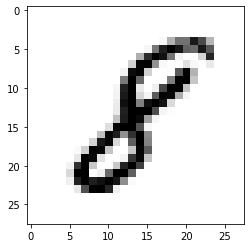

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image_index = 7777 # You may select anything up to 60,000
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')


digits dataset

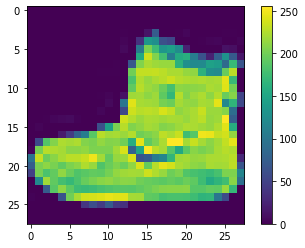

In [7]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

clothes dataset

In [16]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()


def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', input_shape=(image_size,)))

    # The input layer requires the special input_shape parameter which should match
    # the shape of our training data.
    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid'))

    model.add(Dense(units=num_classes, activation='softmax'))

    return model

def evaluate(model):
    model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=16, epochs=30, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    
    
for layers in range(1, 10):
    model = create_dense([32] * layers)
    evaluate(model)

    


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_100 (Dense)            (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________

Test loss: 0.345
Test accuracy: 0.899
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_102 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_103 (Dense)            (None, 10)              

KeyboardInterrupt: 